##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Image Denoising

An autoencoder can also be trained to remove noise from images. In this project, we will create a noisy version of the Fashion MNIST dataset by applying random noise to each image.

We will train an autoencoder using the noisy image as input, and the original image as the target.

In [35]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split

In [37]:
# Loading the dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Data preprocessing: nomralizing and converting images into grey scale
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


We can see from the currrent shapes of x_train and x_test that it is 3-dimensional. There are 60,000 training images and 10,000 testing images, each with a resolution of 28 x 28 pixels.

When we are dealing with Conv2D layers in TensorFlow, the input tensors need to be 4-dimensional. The shape is usually (batch_size, height, width, channels)
So, now we add a new axis at the end of tensor. 1 is included at the end. This represents number of channels. It is because Fashion MNIST has greyscale images.

In [38]:
# adding a new axis at the end of the tensor (for Conv2D compatibility)
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


**Adding random noise to the images**

- `noise_factor` determines the amount of noise to be added to the training and testing images. Here, noise added will be 20% of the maximum possible value (which is 1 in normalized data).

- `x_train + noise_factor * tf.random.normal(shape=x_train.shape)` adds random noise to the training data. `tf.random.normal`generates a tensor with random values from a normal distribution (mean 0, standard deviation 1) of the same shape as x_train. We repeat the same procedure for x_test in `x_test + noise_factor * tf.random.normal(shape=x_test.shape)`

- `tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)` clips the values in `x_train_noisy` to be within the range [0,1]. Values smaller than 0 are set to 0 and values larger than 1 are set to 1. This ensures that the noisy images remain within the valid pixel value range.




In [39]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

# tf.clip_by_value: clips tensor values to a specified min and max
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

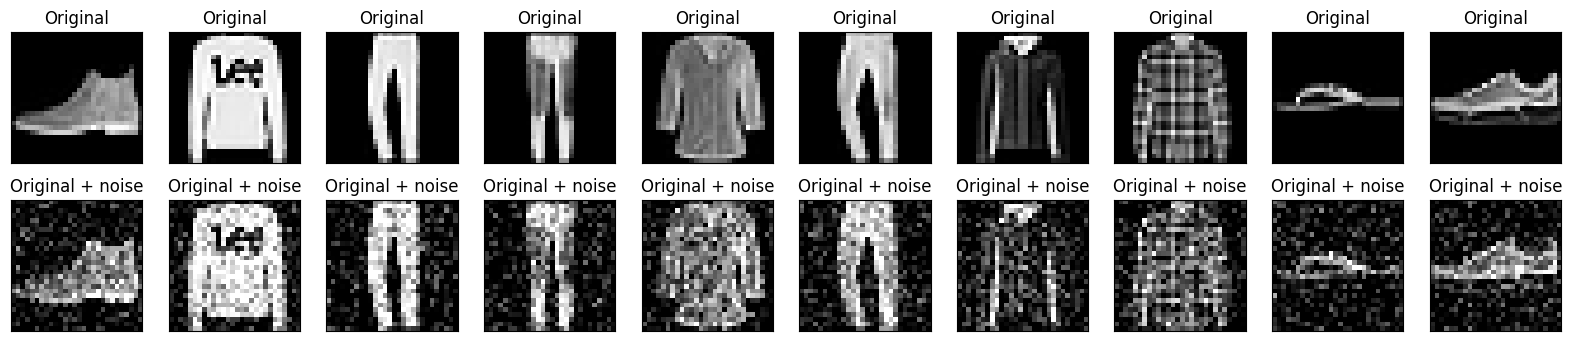

In [40]:
# Visualising original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(tf.squeeze(x_test[i]))
  plt.title("Original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.title("Original + noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

### Defining a convolutional autoencoder

We will train a convolutional autoencoder using Conv2D layers in the `encoder`, and Conv2DTranspose layers in the `decoder`.

In [48]:
# Base model for denoising autoencoder
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(16, (3,3), padding='same', strides=2, activation='relu'),
        layers.Conv2D(8, (3,3), padding='same', strides=2, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, (3,3), strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(16, (3,3), strides=2, padding='same', activation='relu'),
        layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Autoencoder model instantiation
autoencoder = Denoise()

In [49]:
autoencoder.encoder.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [51]:
# observe that we pass the noisy images as input and the original images as target; the same for x_test
# we will train over 10 epochs with shuffled data
history = autoencoder.fit(x_train_noisy,
                          x_train,
                          epochs=10,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 14s 5ms/step - loss: 0.0166 - val_loss: 0.0096
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.00

In [52]:
# checking decoder structure after first instantiation
# The decoder upsamples the images back from 7x7 to 28x28.
autoencoder.decoder.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_12 (Conv2  (None, 14, 14, 8)         584       
 DTranspose)                                                     
                                                                 
 conv2d_transpose_13 (Conv2  (None, 28, 28, 16)        1168      
 DTranspose)                                                     
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


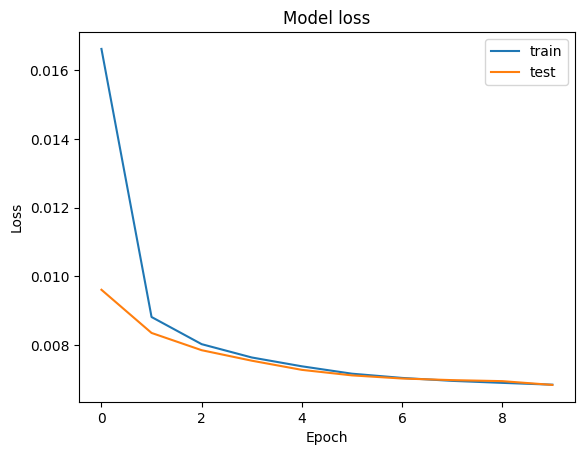

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [54]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

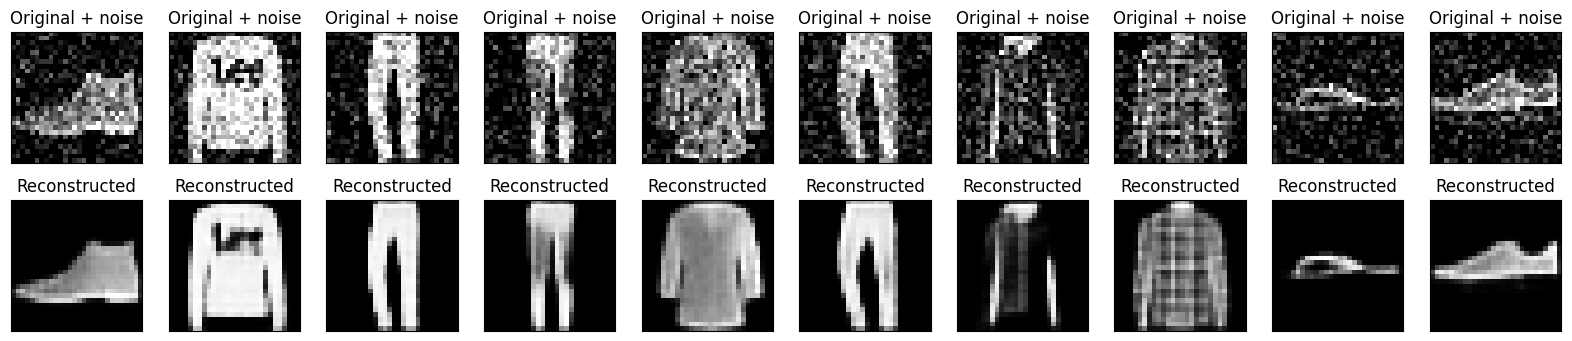

In [55]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("Original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("Reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

From these images, we can see that autoencoder is able to remove noise. The shapes of the items are moreover the same as the targets.